## Pipeline tutorial 102

This notebook is meant to give novice pipeline users a chance to interact with various operators used in the current (early 2022) version of the pipeline which has been used for working with PB-2a data from Feb & March 2021 (the "benchmark" data set). The various databases used with the benchmark data set are reviewed below, as well as some basic manipulations of detector data.

## Important note

I am currently working in a feature branch of the repo (tod_dq_improve) which will be pulled in soon. THE CODE BELOW will work if you check out this branch, or if you wait a bit, I will merge this repo with the "master" branch in the next two weeks.

### Benchmark dataset definition

The pipeline now features a data selection class, sa_cuts.DataSelector, which interacts with a .yaml file of the user's specification to return particular observations ( (run_id, run_subid) tuples) and bolometers to use for each observation. The cuts should be specified on tables and columns in the databases here on tostada1: 

__/data/pb2/ChileData/databases/pb2a-202220405_benchmark_dataset__

See here for more background on the benchmark dataset:
https://bolowiki.berkeley.edu/pub/Main/RebootedPipelineDevelopmentForSA/20211123_benchmark_proposal.pdf

Here's an example excerpt from the data selection file I am currently using (/home/ktcrowley/selection_files/20220228_SA_DS_v1.yaml):
- ces:
  - out: 'DISTINCT run_id, run_subid'
  - pb2a_runid.run_id-1: ">= 22300677"
  - pb2a_runid.run_id-2: "<= 22300832"
  - pb2a_runid.scan_name: "<> 'NULL'"
  - pb2a_runid_g3file.filename: "<> 'NULL'"
  - pb2a_runid.features: '> 0'
  - pb2a_runid.field: "LIKE 'CORE_%'"
  
We can see a couple of things:

- the field in "out" specifies the type of return value being requested from an SQL table/database file, as well as possible conditions (like only distinct runs).
- SQL columns which have multiple conditions (say an "AND" between two comparative conditions) should have lines in the selection file which enumerate their conditions (i.e. run_id-1 & run_id-2 above).
- currently only AND is supported in this framework, but this is sufficient for the current selection tools
- this returns many scans, some of which are not CESes. Culling these requires a different set of tools.

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import simons_array_python.sa_cuts as sa_cuts
ds = sa_cuts.DataSelector(cuts_file='/home/ktcrowley/selection_files/20220228_SA_DS_v1.yaml')
all_ces = ds.ces_query()
print(len(all_ces), all_ces[:10])

/opt/toast/deps/20180828/aux/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO: numpy.fft used.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_runid.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_runid_g3.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_data_quality.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_mapping.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_tuning.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_monitor.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_stim_template.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20220405_benchmark_dataset/pb2a_stim_iq.db attached.
32 [(22300677, 6), (22300677, 10), (22300677, 14), (22300710, 6), (22300710, 10), (223007

These 32 runs are the runs which pass checks on both the run_id and basic checks of what the telescope was doing (scan_name, feature_flag) AND the HWP encoder quality checks I proposed earlier this year. This is a fairly tight subset of scans, but is a good first pass for us.

Part of the restriction is that it also only includes observations which have had their HWP encoder quality, bolometer noise, etc., estimated in the SQL .db files in the database folder above (/data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset).

## Run information from SQL databases

Let's get some information for an example observation in this set.

In [50]:
import importlib
importlib.reload(sa_obs)

<module 'simons_array_python.sa_observation' from '/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_observation.py'>

In [3]:
obs_id = all_ces[6]

import simons_array_python.sa_observation as sa_obs
obs = sa_obs.Observation(obs_id)
obs.load_metadata()

# What was the start date of this run?
import datetime
import simons_array_python.sa_common as sa_comm
first_ctime = sa_comm.mjd_to_unixtime(obs.first_mjd)
date_start = datetime.datetime.fromtimestamp(first_ctime).isoformat()
print(date_start)

# What feature flags are present in this run?
flags = obs.feature_flag_decoder()
print(flags)

Reading SQL table pb2a_runid...done.
2021-02-20T23:04:47.790002
['ces', 'hwp_rotating']


In [17]:
# What detectors can possibly be loaded AND calibrated for this run?
## OPTION 1: obs.load_calibratable_list
## This class method finds all possible detectors which have stimulator data taken within the same tuning period as the obs
## i.e. stimulator data was taken after most recent tune before obs and/or taken before next tune after obs
obs.load_calibratable_list()
calibratable_list = obs.detectors # IMPORTANT! recall this attribute of the "obs" class is the list of detectors which
                                  # which will be loaded when data is loaded from disk -- all ~3000 of them! looping over these
                                  # in a cached operator is recommended
        
## OPTION 2: use sa_pipeline_filters.OperatorCalculateCalibrationFromDB
## This operator will actually calculate the K/ADC values based on stimulator template data (from databases) & whatever
## stimulator amplitude measurements are relevant to this observation
## It adds a new attribute ('calibration_factor_by_boloname') to the observation which can be studied after the operator is run
import simons_array_python.sa_pipeline_filters as sa_pf
cal_op = sa_pf.OperatorCalculateCalibrationFromDB() # Argument structure needs documenation
cal_op.filter_obs(obs)
calculated_calibrations = obs.calibration_factor_by_boloname
calculated_list = list(calculated_calibrations.keys())

## OPTION 3: use data selector!
## simply make call to ds.ces_tes_query(obs.obs_id)
bolos_passing_cuts = [bn_tuple[0] for bn_tuple in ds.ces_tes_query(obs.obs_id)]

Reading SQL table pb2a_pydfmux_time...done.
INFO: Found SQUID tuning 2.8 h before.
Reading SQL table pb2a_tuning...done.
Reading SQL table pb2a_pydfmux_time...done.
INFO: Found SQUID tuning 20.0 h later.
Reading SQL table pb2a_tuning...done.
INFO: found valid stimulator run! [22300749, 22300751, 22300753]
Reading SQL table pb2a_pydfmux_time...done.
INFO: Found SQUID tuning 2.8 h before.
Reading SQL table pb2a_tuning...done.
Reading SQL table pb2a_pydfmux_time...done.
INFO: Found SQUID tuning 6.7 h before.
Reading SQL table pb2a_tuning...done.


In [6]:
print(len(calibratable_list), len(calculated_list))
print(np.all([c in calibratable_list for c in calculated_list]))
print(np.all([c in calculated_list for c in calibratable_list]))

3078 3119
False
True


In [7]:
print(len(bolos_passing_cuts)) # Fairly harsh! Based on getting a good fit to bolometer noise PSD, not overfilling glitch cuts,
                               # other things

684


So far, all of the above is just talking to the existing SQL databases to find information about observations, detectors, etc. Of course this is important prep work for then loading data and using the pipeline -- for instance, we now have the real calibration factors to be used to convert the raw data from disk to a number in brightness temperature K that's good to 20-30%!

## Tuning data

We can now talk a bit about how pydfmux data is currently integrated into the pipeline -- again, before touching any of the actual data for this run!

The first thing to mention is that the tuning database file (usually named something like "pb2a_tuning.db") is somewhat unique. It is NOT keyed by observation ID, because tunings are not associated with particular observations. The main table, which is called pb2a_tuning, is keyed by the ctime of the tuning operation itself.

The tuning database is also somewhat opaque as to WHAT kind of pydfmux operation is happening. For our purposes, a pipeline script runs a batch processing job on all new pydfmux files to find the following types of pydfmux tuning acquisitions:
- bolometer overbias (pydfmux function "overbias_and_null")
- bolometer tuning (pydfmux_function "drop_bolos")
- noise measurement of tuned/overbiased bolos (pydfmux function "measure_noise")

Fortunately, the user of the pipeline does not usually need to wade into these details. There are a couple of options:

1) I have made a table in the tuning db currently being used in our database set called pb2a_tuning_runid which maps an observation id to a tuning time to be loaded. It turns out, due to me not being too careful, that this will ALWAYS refer to a "measure_noise" pydfmux acquisition, NOT the nearest pydfmux "drop_bolos" acquisition. But it IS useful for capturing the most recent time that pydfmux recorded bolometer V, I, NEI, ADC_to_A, etc.

2) Kyohei has a very useful function as part of the observation class called load_tuning_info. This uses a built-in pipeline method in the sa_sql module called get_last_tuning_db, which itself calls a particular function which is built into the python version of the pb2a_tuning table.

In [10]:
# Load tuning info
obs.load_tuning_info()
tune_info = obs.tuning_info

test_bolo = bolos_passing_cuts[444][0] # returned values in bolos_passing_cuts are singleton tuples
# tuning information is keyed by readout_name (WaferXCombYChannelZ)
# converting between one and the other involves an SQL call under the hood to the pb2a_focalplane table
import simons_array_python.sa_pipeline_inputs as sa_pi
test_readout = sa_pi.name_from_bolo_name(test_bolo)

tune_dict = tune_info[[ent['boloid'] for ent in tune_info].index(test_readout)] # This is a dictionary w/ tune properties
print(tune_dict.items()) # Show all attributes

INFO: tuning info for all the wafers is saved within 8 seconds.
INFO: complete loading tuning info for 4928 bolometers.
dict_items([('boloid', 'PB20.13.15_Comb24Ch21'), ('fbias', 3341751.0986328125), ('Cmag', 0.022805693484031376), ('V', 8.013500588996678e-06), ('I', 6.359510635258045e-06), ('I_i', 6.359510634247034e-06), ('I_q', 1.1339785801080275e-10), ('ReZ', 1.2600813250149654), ('ImZ', -2.2468792237978466e-05), ('ADCtoA', 4.53591432043211e-11), ('phase', 129.99925118887205), ('SQZ', None), ('DANg', None), ('NEI_i', None), ('NEI_q', None), ('state', 'tuned'), ('target_rfrac', 0.8270307131876499), ('achieved_rfrac', 0.8515224223752047)])


In [11]:
## ZOOM OUT: what tables are present in the sa_sql module
import simons_array_python.sa_sql as sa_sql
all_python_sql_tables = [k for k in sa_sql.db_impl.__dict__.keys() if '_db' in k]
print(all_python_sql_tables)

['get_last_tuning_db', 'get_next_tuning_db', 'g3file_db', 'runid_db', 'runid_g3file_db', 'focalplane_db', 'hwm_db', 'scan_db', 'monitor_db', 'apex_db', 'darkbolometer_db', 'whwp_db', 'stim_template_db', 'stim_db', 'glitch_db', 'timestream_db', 'scan_synchronous_db', 'pydfmux_time_db', 'squid_tune_time_db', 'tuning_db']


Most of the above are "LazyTables", meaning all data in the table is brought into memory as a Python dictionary with every possible entry available. A couple of exceptions:

- hwm_db, focalplane_db: these are limited to ONLY show SQLite table entries corresponding to the hardware_map_path & hardware_map_commit_hash in your sa_config.py
- glitch_db, timestream_db, scan_synchronous_db: these are "DelayedTables" which, when you request an entry from them, will check to see if they've already cached the result from SQLite, and if not, go and get it for you + cache it
- tuning_db, pydfmux_time_db: these are actually PartialTableGenerators which have a unique call and method and structure setup. I would NOT recommend talking to them directly, but rather using the load_tuning_info call above.

For information from the pb2a_timestream and pb2a_glitch tables, as well as important bolometer hardware information (detector offset, polarization angle, etc.), there is a final Observation object method to demonstrate: load_det_properties.

In [18]:
# This method either accepts an argument "detset", a list of bolo_names to look for, or will attempt to load data
# for all bolo_names in the obs.detectors attribute.
# Currently that attribute is quite large, 
# and it may not align with the database we are attempting to load noise/glitch data from.
# So let's use the list of bolos_passing_cuts, and just the first 50.
det_subset = bolos_passing_cuts[:50]
obs.load_det_properties(detset=det_subset)

# This creates (yet another!) observation attribute called "detector_parameters" which can now be examined by bolo_name.
for bn in det_subset[:5]:
    print(bn, obs.detector_parameters[bn])
    
# In the below, these cal factors are exactly what we calculate when we run OperatorCalculateCalibrationDB.

13.10_10.150B {'readout_name': 'PB20.13.10_Comb20Ch20', 'raw_i_noise_ampl': 0.0035119773162953735, 'raw_i_fknee': 1.9923106730563775, 'raw_i_index': 1.0530766971853702, 'raw_i_fit_flag': 0, 'raw_i_chi2': 576479257.1638056, 'cal_factor': -0.0020720791621992316, 'tes_nans_num': 0, 'raw_i_nglitch': 2, 'det_offset_x': -1.683742, 'det_offset_y': -0.601323, 'pol_angle': 153.44689571402014, 'band': 150, 'pixel_number': 10}
13.10_10.90T {'readout_name': 'PB20.13.10_Comb20Ch29', 'raw_i_noise_ampl': 0.0026393721723201413, 'raw_i_fknee': 14.635299118340562, 'raw_i_index': 1.3907051746048158, 'raw_i_fit_flag': 0, 'raw_i_chi2': 28954759.643830568, 'cal_factor': -0.0025797148558638888, 'tes_nans_num': 0, 'raw_i_nglitch': 5601, 'det_offset_x': -1.693163, 'det_offset_y': -0.601097, 'pol_angle': 57.66571212303279, 'band': 90, 'pixel_number': 10}
13.10_101.150T {'readout_name': 'PB20.13.10_Comb19Ch18', 'raw_i_noise_ampl': 0.0025992074320881076, 'raw_i_fknee': 12.356193572967765, 'raw_i_index': 1.0952553

## Working with detector & HWP data

I will now give a quick run-down on how to load and work with both detector and HWP data, as they're currently implemented in my script scratch/ktcrowley/a6-reprocess_bolo_stats.py. This is meant to take as input many of the database results above (including pb2a_timestream, existing cuts files, etc.).

In [19]:
from simons_array_python.sa_timestream_operators import *
OperatorTODGlitchFinder = sa_cuts.OperatorTODGlitchFinder
h5py = sa_cuts.h5py
OperatorMaskManager = sa_cuts.OperatorMaskManager

import simons_array_python.sa_hwp as sa_hwp
hwp_data_flag = True

cuts_dir = '/home/ktcrowley/cuts_loc/202112_benchmark/'
dump_cuts = False
hwpss_dir = '/home/ktcrowley/hwpss_data/pipeline_102/'

all_dets = bolos_passing_cuts
global_readout_phase = 'I' # the pipeline does allow for phase rotation, but we don't yet have the final estimator/algorithm
                           # for determining the optimal combination of I/Q phase from pydfmux output
global_tod_attr = 'I'
cache_size = 30

In [20]:
# Setting things up for processing.
data_input = sa_pi.InputLevel0CachedByObsID(all_detectors=all_dets, n_per_cache=cache_size, load_g3=True, load_slowdaq=False,
                                            load_dets=True, load_hwp=hwp_data_flag, load_gcp=True,
                                            readout_phase=global_readout_phase,
                                            ignore_faulty_frame=True, ts_rounding_error=1e+10, record_frame_time=False)

# Define plot outputs
PLOT_DIRECTORY = '/scratch/ktcrowley/sa_plots/tes_plot_testdir/tes_plots/202112_benchmark_run/reprocess/pipeline_102/'
output_ff = PlotFileFactoryTarfile(PLOT_DIRECTORY)
zip_tar_after = True

# Define OperatorComposite classes for loop over observations
operator_load_data = sa_pf.OperatorDataInitializer(data_input)

# "pre-process" GCP fields like az position, scan flags, interpolate to bolo sampling
operator_preprocess = sa_pf.OperatorComposite(
    OperatorSubscanRange(az_field_name='az_pos', prefix='', plot=False),
    sa_pf.OperatorTelescopeDataInterpolator(prefix='corrected_', keep_raw=False),
    sa_pf.OperatorScanCorrector('raw_scan_flag', 'raw_scan_flag', 'raw_antenna_time_mjd'),
    sa_pf.OperatorScanCorrector('raw_scan_flag', 'raw_az_pos', 'raw_antenna_time_mjd'))

# Define what cuts already estimated on disk to load, to fill glitch regions > 5 sigma, fill w/ linear interpolation
operator_tod_prep = sa_pf.OperatorComposite(OperatorTODPolyFilter(tod_attr=global_tod_attr, deg=3, apply_LPF=False, 
                                                                  LPF_cutoff=2.0, LPF_order=3),
                                            OperatorMaskManager(tod_attr=global_tod_attr, load_glitches=True, glitch_sig=5., 
                                                                load_nans=True, load_gcp_gaps=False,
                                                                fill_masked_regions=True, mask_turnarounds=False, 
                                                                cuts_file_root=cuts_dir))

# Operator to apply calibration
operator_apply_cal =  sa_pf.OperatorApplyCalibrationFromTOD(unit=cal_op.unit, suffix=global_tod_attr)

# Define spectrum fitting arguments at initialization
spectrum_calc_args = {'mask_hwp': True,  # no filtering applied below
                      'perform_fit': True,
                      'scan_mask_df': 0.005,
                      'calc_weights': True,
                      'calc_num_1f': True,
                      'keep_raw_fft': False,
                      'raw_fft_maxfreq': 4.0,
                      'apodization_frac': 0.04,
                      'pad_kwargs': {'pad': True, 'use_fftw': True},
                      'bound_kwargs': {'fknee_bound': (1.e-2,25.), 'index_bound': (0.5,5.0),
                                       'hinu_range': (19.,31.), 'lonu_range': (0.075, 0.7), 'fit_range': (3.e-2, 40.)}
                      }

operator_evaluate_spectrum = OperatorTODEvalSpectrum(tod_attr=global_tod_attr, 
                                                    eval_attr_name='tes_spectra.raw_%s'% global_tod_attr.lower(),
                                                    plot_file_factory=output_ff,
                                                    plot_file_suffix=('unfilter_%s_spectrum'% (global_tod_attr)),
                                                    calc_args=spectrum_calc_args)

# Define operator to calculate HWP angle, filter HWP synchronous signal
hwp_angle_calc = sa_hwp.HWPAngleCalculator(0., calculate_dq=False)

operator_hwp_hwpss = sa_pf.OperatorComposite(OperatorTODGlitchFinder(tod_attr=global_tod_attr+'_binhwpssfilt', kernel=None, 
                                                                     sigma_threshold=2.5, sigma_fill_threshold=5.,
                                                                    eval_attr_name='glitch.filt_%s'% global_tod_attr.lower(), 
                                                                     fill_glitch=True),
                                             sa_hwp.HWPSignalFilter(demod_modes=[0,4], filter_modes=[], hwpss_bin_remove=True, 
                                                                    demod_band=1.0, # Hz
                                                                    est_fourier_series=False,
                                                                    suffix='-'+global_tod_attr))

# DO NOT mask hwp in fit
spectrum_calc_args['mask_hwp'] = False

# Spectrum fit for HWPSS-filtered PSD
operator_evaluate_hwpfilt = OperatorTODEvalSpectrum(tod_attr=global_tod_attr+'_binhwpssfilt',
                                                    eval_attr_name='tes_spectra.filt_%s'% global_tod_attr.lower(),
                                                    plot_file_factory=output_ff,
                                                    plot_file_suffix=('hwpssfilt_%s_spectrum'% (global_tod_attr)),
                                                    calc_args=spectrum_calc_args)

In [29]:
# Spectrum fit for demod PSD
## guess fit parameters
demod_calc_args = spectrum_calc_args.copy()
demod_calc_args['calc_weights'] = False
demod_calc_args['calc_num_1f'] = False
demod_calc_args['param_guess'] = {'sprime': 0.8, 's': 0.5}

demod_calc_args['bound_kwargs'] = {'fknee_bound': (8.e-4,4.), 'index_bound': (0.1,3.5),
                                    'hinu_range': (0.5,0.75), 'lonu_range': (4.e-3,0.01), 'fit_range': (5.e-4, 1.0)}

operator_evaluate_hwpdemod = sa_pf.OperatorComposite(OperatorTODEvalSpectrum(tod_attr=global_tod_attr+'_4i',
                                                                                 eval_attr_name='tes_spectra.demod_%s_imag'% global_tod_attr.lower(),
                                                                                 plot_file_factory=output_ff,
                                                                                 plot_file_suffix=('demod_%s_U_spectrum'% (global_tod_attr)),
                                                                                 calc_args=demod_calc_args),
                                                     OperatorTODEvalSpectrum(tod_attr=global_tod_attr+'_4r',
                                                                             eval_attr_name='tes_spectra.demod_%s_real'% global_tod_attr.lower(),
                                                                             plot_file_factory=output_ff,
                                                                             plot_file_suffix=('demod_%s_Q_spectrum'% (global_tod_attr)),
                                                                             calc_args=demod_calc_args))

In [21]:
# Define scan_freq (used in plotting PSD)
scan_row = sa_sql.db_impl.scan_db[obs.obs_id]
print('Scan frequency found: {0:.4} Hz'.format(scan_row.scan_freq), file=log_info)
scan_freq = scan_row.scan_freq

setattr(obs, 'scan_freq', scan_freq)

# Set up index ranging for limiting number of bolos loaded to size n_per_cache
min_ind = 0
cache_step = len(all_dets)//cache_size
lo_bolo_index = min_ind*cache_size
hi_bolo_index = (min_ind + cache_step)*cache_size

for i in range(min_ind, min_ind+1):
    init_det_ind = i*cache_size
    if i < len(all_dets)//cache_size:
        final_det_ind = (i+1)*cache_size
    else:
        final_det_ind = len(all_dets)
        
    det_subset =  all_dets[init_det_ind:final_det_ind]
    rn_subset = sa_pi.name_from_bolo_name(det_subset)

    obs.detectors = list(det_subset) # Since this loop is only run once in this NB, all other operator calls can be outside it.
    #print(det_subset)
    
operator_load_data.filter_obs(obs)

Reading SQL table pb2a_scan_stat...done.
Scan frequency found: 0.01057 Hz
INFO: instantiating g3 data buffer from None
Loading data from g3 files for run_id=22300750, run_subid=6 . . . 
Reading SQL table pb2a_runid_g3file...conflicting key: (None, None, 'Run22301615_000.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_000.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_000.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_001.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_001.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_001.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_002.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_002.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_002.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_003.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_003.g3'), sidestepping
conflicting key: (None, None, 'Run22301615_003.g3'

Reading SQL table pb2a_g3file...done.
INFO: Run22300750.6: reading following files: Run22300750_000.g3,Run22300750_001.g3,Run22300750_002.g3,Run22300750_003.g3,Run22300750_004.g3,Run22300750_005.g3,Run22300750_006.g3,Run22300750_007.g3.
INFO: Run22300750.6: frame (total, first, last)=(332, 35, 291).


Setting input name to data


In [22]:
operator_preprocess.filter_obs(obs)

# Set len_sec so that the weighting of the FFT needed to convert to PSD (in OperatorTODEvalSpectrum) is correct.
setattr(obs, 'len_sec', np.ptp(obs.tod_list[0].read_times())*3600.*24)

INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorScanCorrector'>
NEW VECTOR LENGTHS! 387200 383900
INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorScanCorrector'>
NEW VECTOR LENGTHS! 387200 383900
INFO: Applying pipeline filter: <class 'simons_array_python.sa_pipeline_filters.OperatorTelescopeDataInterpolator'>
INFO: Applying pipeline filter: <class 'simons_array_python.sa_cuts.OperatorSubscanRange'>


In [23]:
# Calculate HWP angle and look for problem values
hwp_angle_calc.filter_obs(obs)
print('INFO: Num problem samples for HWP angle estimate', np.sum(obs.tod_list[0].read('hwp_angle') < 0.))

Overflow increment fail search, clk counts
Overflow increment fail search, clk counts @ ref
Overflow increment fail search, IRIG clk counts
Raw diff : median  768.0  , max  997  , min  539
Raw diff : median  5.0  , max  4294901766  , min  3
Raw diff : median  16054280.0  , max  16054440  , min  16054155
Clock gaps []
IRIG clock gaps []
Encoder gaps [(53190474, 7, 5.0, 5.0, (53190453, 53190473), (53190474, 53190495))]
585
1376
3569
3748
3815
7171
8514
9272
10493
11142
11744
13670
14528
15825
16417 16417
16403 16403
Number of overflows in TOD 5856.0 Expected time 3837.7881600000005 Real time 3838.9940219465643
Find approximate encoder count sample rate 20930.63984405458
Number of ok ref holes 722
Calculated hwp speed 1.9968533342753185
INFO: Num problem samples for HWP angle estimate 0


In [24]:
# Load and apply cuts, poly filter entire TOD
operator_tod_prep.filter_obs(obs)

INFO: Applying pipeline filter: <class 'simons_array_python.sa_cuts.OperatorMaskManager'>
INFO: defining new eval attribute tes_mask_ranges
INFO: Applying pipeline filter: <class 'simons_array_python.sa_timestream_operators.OperatorTODPolyFilter'>


In [25]:
# Apply calibration
operator_apply_cal.filter_obs(obs)

In [26]:
# Estimate spectrum, plot results
operator_evaluate_spectrum.filter_obs(obs)

INFO: looking for TES 13.10_10.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.9362,offset=-4.9967 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_10.150B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_10.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-0.92759,offset=-4.9218 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_10.90T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_101.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3474,offset=-5.1685 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_101.150T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_101.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.915,offset=-5.8931 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_101.90B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_107.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3263,offset=-5.1962 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_107.150B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_109.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.6299,offset=-5.5403 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_109.90T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_110.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.4182,offset=-5.2743 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_110.150B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_110.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.0363,offset=-5.9655 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_110.90T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_111.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.8359,offset=-5.7123 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_111.90T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_114.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.954,offset=-5.8558 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_114.90T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_119.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3012,offset=-5.1491 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_119.150B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_123.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3204,offset=-5.152 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_123.150B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_123.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.332,offset=-5.2392 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_123.150T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_124.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3607,offset=-5.2173 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_124.150T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_124.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.9247,offset=-5.9802 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_124.90B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_124.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.3361,offset=-5.4724 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_124.90T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_130.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.7076,offset=-5.6696 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_130.90T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_138.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3694,offset=-5.2115 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_138.150B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_14.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.1666,offset=-3.7008 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_14.90B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_140.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-0.87135,offset=-4.6179 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_140.90B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_141.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3413,offset=-5.1688 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_141.150T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_142.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3624,offset=-5.2398 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_142.150B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_142.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3605,offset=-5.2215 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_142.150T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_143.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.7833,offset=-5.8742 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_143.90T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_153.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.7871,offset=-4.1443 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_153.150B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_157.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.9481,offset=-5.9867 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_157.90B__unfilter_I_spectrum.png


INFO: looking for TES 13.10_159.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3111,offset=-5.1945 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_159.150T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_160.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3104,offset=-5.1485 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_160.150T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_164.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.6653,offset=-5.6364 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_164.90T__unfilter_I_spectrum.png


INFO: looking for TES 13.10_167.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.095,offset=-6.0655 for f in between 0.075 and 0.7 Hz
INFO: defining new eval attribute tes_spectra.raw_i


wrote 22300750.6/pb2a_13.10_167.90B__unfilter_I_spectrum.png


In [27]:
# Estimate and filter HWPSS plus calculate and plot filtered PSD
operator_hwp_hwpss.filter_obs(obs)
operator_evaluate_hwpfilt.filter_obs(obs)

INFO: Applying pipeline filter: <class 'simons_array_python.sa_hwp.HWPSignalFilter'>


/opt/toast/deps/20180828/conda/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/toast/deps/20180828/conda/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/toast/deps/20180828/conda/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


INFO: defining new eval attribute hwpss_data
INFO: Applying pipeline filter: <class 'simons_array_python.sa_cuts.OperatorTODGlitchFinder'>
Kernel nonzero index sizes 14 5
INFO: defining new eval attribute glitch.filt_i
INFO: looking for TES 13.10_10.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.9351,offset=-4.9958 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_10.150B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_10.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-0.95254,offset=-4.9384 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_10.90T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_101.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3534,offset=-5.1734 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_101.150T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_101.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.0485,offset=-5.9997 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_101.90B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_107.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3424,offset=-5.2099 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_107.150B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_109.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.7889,offset=-5.6765 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_109.90T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_110.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.4244,offset=-5.2794 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_110.150B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_110.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.1567,offset=-6.0683 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_110.90T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_111.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.9167,offset=-5.7827 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_111.90T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_114.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.0928,offset=-5.9744 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_114.90T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_119.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.308,offset=-5.1547 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_119.150B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_123.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3325,offset=-5.1621 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_123.150B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_123.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3411,offset=-5.2469 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_123.150T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_124.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3762,offset=-5.2299 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_124.150T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_124.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.0763,offset=-6.111 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_124.90B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_124.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.4083,offset=-5.5329 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_124.90T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_130.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.7911,offset=-5.7412 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_130.90T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_138.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3759,offset=-5.2166 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_138.150B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_14.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.9428,offset=-4.399 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_14.90B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_140.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-0.86559,offset=-4.6098 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_140.90B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_141.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3495,offset=-5.1757 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_141.150T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_142.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3676,offset=-5.2445 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_142.150B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_142.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3804,offset=-5.2374 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_142.150T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_143.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.9618,offset=-6.0233 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_143.90T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_153.150B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.7865,offset=-4.1429 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_153.150B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_157.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.9099,offset=-5.9436 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_157.90B__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_159.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3253,offset=-5.2064 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_159.150T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_160.150T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.3275,offset=-5.1622 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_160.150T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_164.90T
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-1.7382,offset=-5.6998 for f in between 0.075 and 0.7 Hz


wrote 22300750.6/pb2a_13.10_164.90T__hwpssfilt_I_spectrum.png


INFO: looking for TES 13.10_167.90B
INFO: padded array from size 585785 to size 589824
INFO: padded length 589824 scaling up length of timestream from N=585785
INFO: determine index=-2.2877,offset=-6.2261 for f in between 0.075 and 0.7 Hz
INFO: defining new eval attribute tes_spectra.filt_i


wrote 22300750.6/pb2a_13.10_167.90B__hwpssfilt_I_spectrum.png


In [30]:
operator_evaluate_hwpdemod.filter_obs(obs)

INFO: Applying pipeline filter: <class 'simons_array_python.sa_timestream_operators.OperatorTODEvalSpectrum'>
INFO: looking for TES 13.10_10.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)
wrote 22300750.6/pb2a_13.10_10.150B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_10.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_10.90T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:493: RuntimeWarning: invalid value encountered in double_scalars
  fknee_initial = (B/A)**(1./self.sprime)
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_101.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831
INFO: looking for TES 13.10_101.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_101.90B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_107.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_107.150B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_109.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_109.90T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_110.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_110.150B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_110.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_110.90T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_111.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_111.90T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_114.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_114.90T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:493: RuntimeWarning: invalid value encountered in double_scalars
  fknee_initial = (B/A)**(1./self.sprime)
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_119.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_119.150B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_123.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_123.150B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_123.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_123.150T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_124.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_124.150T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_124.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_124.90B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_124.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831
INFO: looking for TES 13.10_130.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_130.90T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_138.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_138.150B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_14.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_14.90B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_140.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_140.90B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_141.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_141.150T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_142.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_142.150B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_142.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_142.150T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_143.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_143.90T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:493: RuntimeWarning: invalid value encountered in double_scalars
  fknee_initial = (B/A)**(1./self.sprime)
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_153.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831
INFO: looking for TES 13.10_157.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_157.90B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_159.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_159.150T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_160.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_160.150T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_164.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_164.90T__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_167.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_167.90B__demod_I_Q_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: defining new eval attribute tes_spectra.demod_i_real
INFO: Applying pipeline filter: <class 'simons_array_python.sa_timestream_operators.OperatorTODEvalSpectrum'>
INFO: looking for TES 13.10_10.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_10.150B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_10.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_10.90T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/simons_array_python/sa_timestream_operators.py:493: RuntimeWarning: invalid value encountered in double_scalars
  fknee_initial = (B/A)**(1./self.sprime)
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_101.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831
INFO: looking for TES 13.10_101.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_101.90B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_107.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_107.150B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_109.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_109.90T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_110.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_110.150B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_110.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_110.90T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_111.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_111.90T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_114.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_114.90T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_119.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_119.150B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_123.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_123.150B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_123.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_123.150T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_124.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_124.150T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_124.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_124.90B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_124.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831
INFO: looking for TES 13.10_130.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_130.90T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_138.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_138.150B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_14.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_14.90B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_140.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_140.90B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_141.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_141.150T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_142.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_142.150B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_142.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_142.150T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_143.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_143.90T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_153.150B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831
INFO: looking for TES 13.10_157.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_157.90B__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_159.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_159.150T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_160.150T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831


wrote 22300750.6/pb2a_13.10_160.150T__demod_I_U_spectrum.png
/home/ktcrowley/simons_array_offline_software/kms_git/kms_plot/kms_plot.py:878: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xmax=xmax)


INFO: looking for TES 13.10_164.90T
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831
INFO: looking for TES 13.10_167.90B
INFO: padded array from size 30831 to size 32768
INFO: padded length 32768 scaling up length of timestream from N=30831
INFO: defining new eval attribute tes_spectra.demod_i_imag


wrote 22300750.6/pb2a_13.10_167.90B__demod_I_U_spectrum.png


In [31]:
# Close open cuts file
assert(isinstance(operator_tod_prep.chain[-1], OperatorMaskManager))
operator_tod_prep.chain[-1].close_cuts_file() 

# Close output file factor
output_ff.close()

In [32]:
# Let's look at our results!
%cd /scratch/ktcrowley/sa_plots/tes_plot_testdir/tes_plots/202112_benchmark_run/reprocess/pipeline_102/
!ls
!tar -xf 22300750.6.tar
%cd 22300750.6/

/scratch/ktcrowley/sa_plots/tes_plot_testdir/tes_plots/202112_benchmark_run/reprocess/pipeline_102
22300750.6.tar
/scratch/ktcrowley/sa_plots/tes_plot_testdir/tes_plots/202112_benchmark_run/reprocess/pipeline_102/22300750.6


In [33]:
from IPython.display import Image
test_bn = all_dets[9]
print(test_bn)
Image("pb2a_{}__unfilter_I_spectrum.png".format(test_bn))

13.10_114.90T


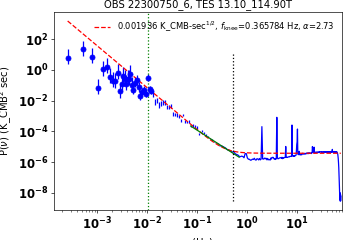

In [34]:
Image("pb2a_{}__hwpssfilt_I_spectrum.png".format(test_bn))

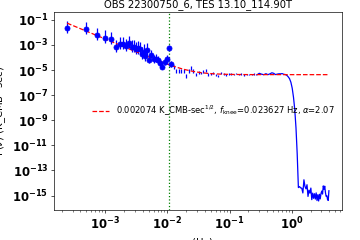

In [35]:
Image("pb2a_{}__demod_I_Q_spectrum.png".format(test_bn))

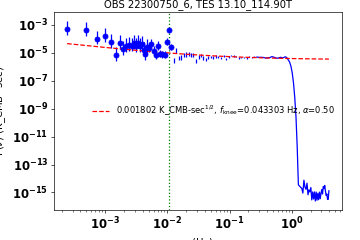

In [36]:
Image("pb2a_{}__demod_I_U_spectrum.png".format(test_bn))